In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

In [161]:
### Mes foctions ###

# Crée une colonne indiquant si la personne a des études en adéquation avec son département
def definir_match_etudes_poste(row):
    """
    Retourne 1 si les études correspondent au département, 0 sinon.
    """
    etudes = row['domaine_etude']
    dept = row['departement']
    
    # 1. Dictionnaire de correspondance (Etudes -> Départements acceptables)
    mapping_logique = {
        # Les Techs vont au Consulting
        'Infra & Cloud': ['Consulting'],
        'Transformation Digitale': ['Consulting'],
        
        # Les Business vont au Commercial
        'Marketing': ['Commercial'],
        'Entrepreunariat': ['Commercial'],
        
        # Les RH vont aux RH
        'Ressources Humaines': ['Ressources Humaines']
    }
    
    # 2. Gestion du cas "Autre" (Option A : On considère que c'est OK)
    if etudes == 'Autre':
        return 1 
        
    # 3. Vérification standard
    # On regarde si le département actuel est dans la liste autorisée pour ces études
    if etudes in mapping_logique:
        if dept in mapping_logique[etudes]:
            return 1 # C'est un Match
        else:
            return 0 # C'est un Mismatch (ex: Marketing -> Consulting)
            
    # Sécurité pour les cas imprévus
    return 0

In [162]:

df_eval = pd.read_csv("./extrait_eval.csv")
df_sirh = pd.read_csv("./extrait_sirh.csv")
df_sondage = pd.read_csv("./extrait_sondage.csv")

In [163]:
# Exploration des données

# on converti la colonne df["eval_number"] en nombre, voir si on peut faire un rapprochement
# avec l'id et le numéro de sondage => OUI c'est le cas


df_eval['eval_number'] = df_eval['eval_number'].str.lower().str.replace('e_', '').astype(int)

In [164]:
# Logiquement l'id = le numero d'éval et de sondage
# donc on va faire la jointure là-dessus
# On drop à chaque fois la colonne de droite car la jointure garde les deux colonnes left et right
# sur lesquelles on fait la jointure
df_final = (
    df_eval
    .merge(df_sirh, left_on='eval_number', right_on='id_employee')  # Jointure 1
    .drop(columns=['id_employee'])                     # Nettoyage 1
    .merge(df_sondage, left_on='eval_number', right_on='code_sondage')   # Jointure 2 (on réutilise 'id' qui vient de df1)
    .drop(columns=['code_sondage'])                      # Nettoyage 2
)

In [165]:
# ont uniquement la valeur 1, partout donc on enlève
df_clean = df_final.drop(columns=["nombre_employee_sous_responsabilite","ayant_enfants"])
# n'a que la valeur 80 donc on enlève également
df_clean = df_clean.drop(columns="nombre_heures_travailless")
# on enlève également les id
df_clean = df_clean.drop(columns="eval_number")

In [166]:
###################################
#       FEATURE ENGINEERING       #
###################################


# Calcul du ratio année depuis la dernière promotion / années dans l'entreprise
# si =0 alors c'est plutot positif, plus on s'approche de 1 plus c'est négatif
# les nouveaux arrivés ont 0 années dans l'entreprise et on met le ratio à 0

df_clean['Ratio_Stagnation'] = np.where(
    df_clean['annees_dans_l_entreprise'] == 0, 
    0, 
    df_clean['annees_depuis_la_derniere_promotion'] / df_clean['annees_dans_l_entreprise']
)

# Application de la fonction pour créer la nouvelle colonne
df_clean['match_etudes_poste'] = df_clean.apply(definir_match_etudes_poste, axis=1)

# 1. On calcule le salaire médian pour chaque groupe (Poste + Niveau d'étude)
# La fonction 'transform' permet de remettre cette valeur sur chaque ligne de l'employé correspondant
df_clean['salaire_median_ref'] = df_clean.groupby(['poste', 'niveau_education'])['revenu_mensuel'].transform('median')

# 2. On crée le Ratio de Compétitivité (Compa-Ratio)
df_clean['ratio_competitivite_salaire'] = df_clean['revenu_mensuel'] / df_clean['salaire_median_ref']

df_clean['duree_moyenne_par_poste'] = df_clean['annee_experience_totale'] / (df_clean['nombre_experiences_precedentes'] + 1)

In [167]:
# On supprime les colonnes qui seraient trop redondante suite au data engineering
df_clean = df_clean.drop(columns=['domaine_etude', 'annees_depuis_la_derniere_promotion', 'nombre_experiences_precedentes'])

In [168]:
# on supprime les colonnes trop corrélées d'après le profiling généré auparavant
df_clean = df_clean.drop(columns=['age', 'departement', 'note_evaluation_actuelle','revenu_mensuel','niveau_hierarchique_poste'])

In [169]:
# On transforme Oui et Non en 0 et 1 ; Pareil pour le genre
from ydata_profiling import ProfileReport


df_clean['a_quitte_l_entreprise'] = df_clean['a_quitte_l_entreprise'].map({'Oui': 1, 'Non': 0})
df_clean['heure_supplementaires'] = df_clean['heure_supplementaires'].map({'Oui': 1, 'Non': 0})
df_clean['genre'] = df_clean['genre'].map({'M': 0, 'F': 1})
# Vérification pour être sur
# print("Valeurs uniques dans la target :", df_clean['a_quitte_l_entreprise'].unique())

# On corrige des strings qui sont en fait des nombres
# en fait non bizarrement sur cet ordi c'est déjà transformé...
df_clean['augementation_salaire_precedente'] = df_clean['augementation_salaire_precedente'].str.replace('%', '').astype(int)

profile = ProfileReport(df_clean, title="Rapport d'Exploration du data frame final")
profile.to_file("mon_rapport.html")

# Petites colonnes avec peux de possibilités qu'on one-hot encode
df_clean = pd.get_dummies(
    df_clean, 
    #columns=['frequence_deplacement','poste','departement','statut_marital'],
    columns=['frequence_deplacement','poste','statut_marital'], 
    drop_first=True,   # Pour éviter la redondance (ex: si ce n'est ni Occasionnel ni Fréquent, c'est forcément Aucun)
    dtype=int          # Pour avoir des 0 et 1 (au lieu de True/False)
)

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 170.83it/s]


In [170]:

# profile = ProfileReport(df_clean, title="Rapport d'Exploration du data frame final")
# profile.to_file("mon_rapport.html")

--- Démarrage de la Cross-Validation (5 folds) ---
Scores F1 des 5 folds : [0.14285714 0.375      0.30434783 0.31111111 0.19047619]
F1 moyen : 0.2648 (+/- 0.1703)

--- Rapport de Classification ---
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       247
           1       0.57      0.09      0.15        47

    accuracy                           0.84       294
   macro avg       0.71      0.54      0.53       294
weighted avg       0.81      0.84      0.79       294


--- Matrice de Confusion ---


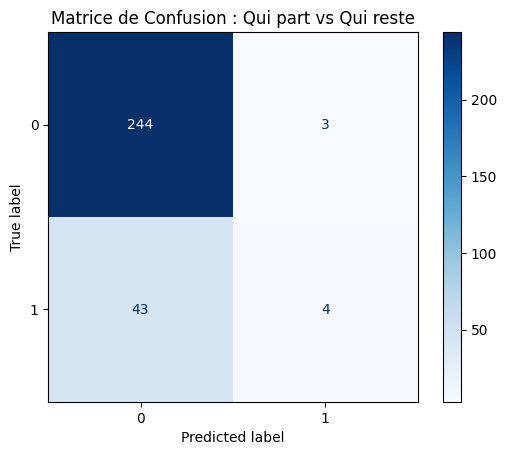

In [171]:
# 1. Préparation du train test
X = df_clean.drop(columns=['a_quitte_l_entreprise'])
y = df_clean['a_quitte_l_entreprise']

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Modèle
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
# class_weight='balanced' pour forcer la Forêt à donner plus d'importance aux employés 
# qui partent (la classe minoritaire).

# 4. Cross-Validation avec F1-SCORE au lieu de l'Accuracy
# Le F1-score est bien meilleur pour juger si on attrape bien les départs car les classes ne sont
# pas balanced
print("--- Démarrage de la Cross-Validation (5 folds) ---")
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1')

print(f"Scores F1 des 5 folds : {cv_scores}")
print(f"F1 moyen : {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# 5. Entraînement final
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# 6. Matrice de Confusion et Rapport
print("\n--- Rapport de Classification ---")
print(classification_report(y_test, y_pred))

print("\n--- Matrice de Confusion ---")
# Affichage graphique propre dans le notebook
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')
plt.title("Matrice de Confusion : Qui part vs Qui reste")
plt.show()

In [172]:
from sklearn.model_selection import GridSearchCV

# 1. Définir la grille des paramètres à tester
# On teste différentes "formes" de forêt pour voir laquelle attrape le mieux les départs
param_grid = {
    'n_estimators': [100, 200],           # Nombre d'arbres
    'max_depth': [5, 10, 20, None],       # Profondeur max (None = illimité)
    'min_samples_leaf': [1, 2, 4],        # Nombre min de feuilles (évite le surapprentissage)
    'class_weight': ['balanced', 'balanced_subsample'] # Gestion du déséquilibre
}

# 2. Initialiser le GridSearch
# LE POINT CLÉ EST ICI : scoring='recall'
# Cela dit au modèle : "Ton but unique est de maximiser le rappel sur la classe 1 (les départs)"
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='recall',  # On peut aussi mettre 'f1' si on veut garder un équilibre
    cv=5,              # 5 validations croisées
    n_jobs=-1,         # Utilise tous les cœurs du processeur
    verbose=2
)

# 3. Lancer la recherche (peut prendre 1 ou 2 minutes)
print("Recherche des meilleurs paramètres en cours...")
grid_search.fit(X_train, y_train)

# 4. Résultats
print(f"\nMeilleurs paramètres trouvés : {grid_search.best_params_}")
print(f"Meilleur score de Recall validé : {grid_search.best_score_:.4f}")

# On récupère le meilleur modèle pour la suite
best_rf = grid_search.best_estimator_

Recherche des meilleurs paramètres en cours...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=1, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=1, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=1, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=1, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=1, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=1, n_estimators=200; total time=   0.2s
[CV] END class_weight=balanced, max_depth=5, min_samples_leaf=1, n_estimato

--- Résultats du Modèle Optimisé ---
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       247
           1       0.42      0.55      0.48        47

    accuracy                           0.81       294
   macro avg       0.66      0.70      0.68       294
weighted avg       0.83      0.81      0.82       294



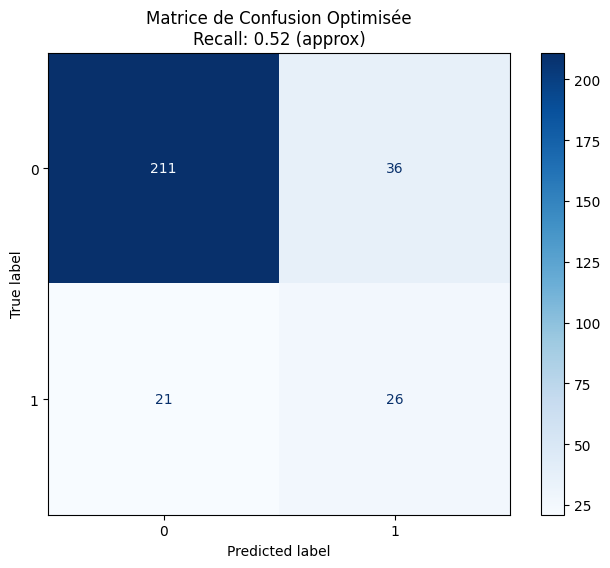

In [173]:
# 1. Récupération du meilleur modèle (déjà réentraîné)
best_rf = grid_search.best_estimator_

# 2. Prédictions sur le jeu de test
y_pred_optimised = best_rf.predict(X_test)

# 3. Rapport de Classification
print("--- Résultats du Modèle Optimisé ---")
print(classification_report(y_test, y_pred_optimised))

# 4. Affichage de la Matrice de Confusion
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_optimised)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(cmap='Blues', ax=ax)
ax.set_title(f"Matrice de Confusion Optimisée\nRecall: {0.52:.2f} (approx)")
plt.show()

In [174]:
# Un peu mieux mais toujours pas foufou, on va essayerd'abaisser le seuil tout simplement
# On demande les probabilités (ex: [0.8, 0.2] -> 20% de chance de partir)
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Testons un seuil plus bas pour attraper plus de monde
nouveau_seuil = 0.40  # Essayez de changer ce chiffre (0.35, 0.45...)
y_pred_seuil = (y_proba >= nouveau_seuil).astype(int)

print(f"--- Résultats avec Seuil abaissé à {nouveau_seuil*100}% ---")
print(classification_report(y_test, y_pred_seuil))

# Comparaison rapide des matrices
cm_seuil = confusion_matrix(y_test, y_pred_seuil)
print(f"Vrais départs détectés (Recall) : {cm_seuil[1,1]} / {cm_seuil[1,:].sum()}")

--- Résultats avec Seuil abaissé à 40.0% ---
              precision    recall  f1-score   support

           0       0.92      0.68      0.78       247
           1       0.29      0.68      0.41        47

    accuracy                           0.68       294
   macro avg       0.60      0.68      0.59       294
weighted avg       0.82      0.68      0.72       294

Vrais départs détectés (Recall) : 32 / 47


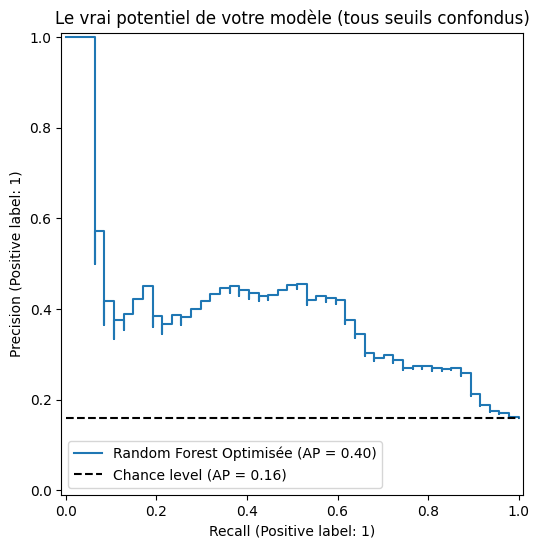

In [175]:
# Utilisation de la courbe ROC pour déterminer le meilleur paramède de seuil

from sklearn.metrics import PrecisionRecallDisplay

# On utilise le best_estimator_ trouvé par le GridSearch
fig, ax = plt.subplots(figsize=(8, 6))

disp = PrecisionRecallDisplay.from_estimator(
    best_rf, 
    X_test, 
    y_test, 
    name="Random Forest Optimisée",
    plot_chance_level=True,  # Affiche la ligne de hasard pour comparer
    ax=ax
)

ax.set_title("Le vrai potentiel de votre modèle (tous seuils confondus)")
plt.show()

In [176]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# 1. On récupère les points de la courbe
y_probas = best_rf.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probas)

# 2. On calcule le F1-Score pour CHAQUE seuil possible
# F1 = 2 * (Precision * Recall) / (Precision + Recall)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# 3. On trouve l'index du meilleur F1
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"--- Le Seuil Optimal Mathématique ---")
print(f"Meilleur Seuil (Threshold) : {best_threshold:.4f}")
print(f"F1-Score associé : {best_f1:.4f}")
print(f"Recall associé   : {recalls[best_index]:.4f}")
print(f"Precision associée: {precisions[best_index]:.4f}")

# 4. Appliquons ce seuil pour voir le résultat final
y_pred_optimal = (y_probas >= best_threshold).astype(int)

print("\n--- Résultat avec ce seuil ---")
print(confusion_matrix(y_test, y_pred_optimal))

--- Le Seuil Optimal Mathématique ---
Meilleur Seuil (Threshold) : 0.4856
F1-Score associé : 0.5000
Recall associé   : 0.6170
Precision associée: 0.4203

--- Résultat avec ce seuil ---
[[207  40]
 [ 18  29]]
